# Corpus Trajectory Analysis: 52 Canonical Poems

This notebook processes all 52 poems in the corpus and calculates trajectory metrics for each.

**Goal**: Generate comparative dataset to test the hypothesis that real poetry shows HIGH DISPERSION + HIGH INTEGRATION.

**Output**: Master CSV file with all metrics for statistical analysis.

## 1. Setup

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim.downloader as api
from pathlib import Path
import json
from typing import List, Dict, Tuple
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)
np.random.seed(42)

print('✓ Packages imported')

✓ Packages imported


In [2]:
# Load Word2Vec model (only once for all poems!)
print("Loading Word2Vec model...")
w2v_model = api.load('word2vec-google-news-300')
print(f"✓ Model loaded: {len(w2v_model)} words, {w2v_model.vector_size}D embeddings")

Loading Word2Vec model...
✓ Model loaded: 3000000 words, 300D embeddings


## 2. Define Helper Functions

These are the same trajectory metric functions from the Oread notebook.

In [3]:
# Copy all the trajectory metric functions here

def get_sequential_embeddings(words: List[str], model, verbose: bool = False) -> Tuple[np.ndarray, List[str]]:
    """Extract sequential word embeddings, preserving order."""
    embeddings = []
    valid_words = []
    
    for word in words:
        try:
            if word in model:
                embeddings.append(model[word])
                valid_words.append(word)
            elif word.lower() in model:
                embeddings.append(model[word.lower()])
                valid_words.append(word.lower())
            elif word.capitalize() in model:
                embeddings.append(model[word.capitalize()])
                valid_words.append(word.capitalize())
            else:
                if verbose:
                    print(f"  Word '{word}' not found")
        except KeyError:
            if verbose:
                print(f"  Word '{word}' not found")
    
    if len(embeddings) == 0:
        raise ValueError("No words found in model vocabulary!")
    
    return np.array(embeddings), valid_words


def cosine_distance(v1: np.ndarray, v2: np.ndarray) -> float:
    """Calculate cosine distance between two vectors."""
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    if norm_product == 0:
        return 2.0
    return 1.0 - (dot_product / norm_product)


def semantic_path_length(embeddings: np.ndarray) -> float:
    """Calculate total semantic distance traversed."""
    if len(embeddings) < 2:
        return 0.0
    total_distance = 0.0
    for i in range(len(embeddings) - 1):
        total_distance += cosine_distance(embeddings[i], embeddings[i+1])
    return total_distance


def net_semantic_displacement(embeddings: np.ndarray) -> float:
    """Calculate direct semantic distance from beginning to end."""
    if len(embeddings) < 2:
        return 0.0
    return cosine_distance(embeddings[0], embeddings[-1])


def tortuosity(embeddings: np.ndarray, epsilon: float = 1e-6) -> float:
    """Calculate tortuosity: ratio of path length to net displacement."""
    spl = semantic_path_length(embeddings)
    nsd = net_semantic_displacement(embeddings)
    if nsd < epsilon:
        return np.inf if spl > epsilon else 1.0
    return spl / max(nsd, epsilon)


def exploration_radius(embeddings: np.ndarray) -> float:
    """Calculate average distance of all words from semantic centroid."""
    if len(embeddings) < 2:
        return 0.0
    centroid = np.mean(embeddings, axis=0)
    distances = [cosine_distance(emb, centroid) for emb in embeddings]
    return np.mean(distances)


def velocity_profile_variance(embeddings: np.ndarray) -> float:
    """Calculate variance in step-by-step semantic velocity."""
    if len(embeddings) < 3:
        return 0.0
    step_distances = []
    for i in range(len(embeddings) - 1):
        step_distances.append(cosine_distance(embeddings[i], embeddings[i+1]))
    return np.var(step_distances)


def directional_consistency(embeddings: np.ndarray, n_components: int = 2) -> float:
    """Measure how often trajectory changes direction in semantic space."""
    if len(embeddings) < 3:
        return 1.0
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components)
    points = pca.fit_transform(embeddings)
    angles_cos = []
    for i in range(len(points) - 2):
        v1 = points[i+1] - points[i]
        v2 = points[i+2] - points[i+1]
        norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
        if norm_product > 0:
            cos_angle = np.dot(v1, v2) / norm_product
            angles_cos.append(cos_angle)
    if len(angles_cos) == 0:
        return 1.0
    return np.mean(angles_cos)


def calculate_all_metrics(embeddings: np.ndarray, words: List[str] = None) -> Dict[str, float]:
    """Calculate all trajectory metrics for a sequence of embeddings."""
    n = len(embeddings)
    metrics = {
        'num_words': n,
        'spl': semantic_path_length(embeddings),
        'nsd': net_semantic_displacement(embeddings),
        'tortuosity': tortuosity(embeddings),
        'rto': net_semantic_displacement(embeddings),
        'exploration_radius': exploration_radius(embeddings),
        'velocity_variance': velocity_profile_variance(embeddings),
        'directional_consistency': directional_consistency(embeddings),
    }
    if n > 1:
        metrics['spl_normalized'] = metrics['spl'] / (n - 1)
    else:
        metrics['spl_normalized'] = 0.0
    return metrics

print('✓ Trajectory functions defined')

✓ Trajectory functions defined


## 3. Load Poem Files and Extract Text

Read all .txt files from `corpus_texts/` directory.

In [4]:
# Define paths
corpus_dir = Path('corpus_texts')
metadata_dir = Path('Metadata/corpus_metadata')

# Get all poem files
poem_files = sorted(corpus_dir.glob('*.txt'))
print(f"Found {len(poem_files)} poem files")

# Show first few
for pf in poem_files[:5]:
    print(f"  {pf.name}")
print("  ...")

Found 49 poem files
  004_epithalamion.txt
  005_the_passionate_shepherd_to_his_love.txt
  006_shall_i_compare_thee_to_a_summers_day.txt
  007_the_description_of_cooke_ham.txt
  008_the_good_morrow.txt
  ...


In [5]:
def read_poem_file(filepath: Path) -> Tuple[str, str, int, List[str]]:
    """
    Read a poem text file and extract metadata + word list.
    
    Returns:
        title, author, year, word_list
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    # Parse header
    title = lines[0].replace('TITLE:', '').strip()
    author = lines[1].replace('AUTHOR:', '').strip()
    year = int(lines[2].replace('YEAR:', '').strip())
    
    # Extract poem text (skip header and blank line)
    poem_text = ''.join(lines[4:])
    
    # Tokenize: split on whitespace and remove punctuation
    import re
    words = re.findall(r"\b[\w']+\b", poem_text)
    
    return title, author, year, words

# Test on first file
test_title, test_author, test_year, test_words = read_poem_file(poem_files[0])
print(f"Test: '{test_title}' by {test_author} ({test_year})")
print(f"  {len(test_words)} words")
print(f"  First 10: {test_words[:10]}")

Test: 'Epithalamion' by Edmund Spenser (1595)
  3244 words
  First 10: ['Ye', 'learned', 'sisters', 'which', 'have', 'oftentimes', 'Beene', 'to', 'me', 'ayding']


## 4. Process All Poems

Loop through all 52 poems and calculate trajectory metrics.

In [6]:
# Initialize results list
results = []
errors = []

print(f"Processing {len(poem_files)} poems...\n")

for poem_file in tqdm(poem_files, desc="Analyzing poems"):
    try:
        # Extract poem ID from filename (e.g., "001_title.txt" -> 1)
        poem_id = int(poem_file.stem.split('_')[0])
        
        # Read poem
        title, author, year, words = read_poem_file(poem_file)
        
        # Get embeddings
        embeddings, valid_words = get_sequential_embeddings(words, w2v_model, verbose=False)
        
        # Calculate metrics
        metrics = calculate_all_metrics(embeddings, valid_words)
        
        # Store results
        result = {
            'poem_id': poem_id,
            'filename': poem_file.name,
            'title': title,
            'author': author,
            'year': year,
            'total_words': len(words),
            'valid_words': len(valid_words),
            'coverage': len(valid_words) / len(words) if len(words) > 0 else 0,
        }
        result.update(metrics)
        results.append(result)
        
    except Exception as e:
        error_msg = f"Error processing {poem_file.name}: {str(e)}"
        print(error_msg)
        errors.append(error_msg)
        continue

print(f"\n✓ Processed {len(results)} poems successfully")
if errors:
    print(f"✗ {len(errors)} errors occurred")
    for err in errors:
        print(f"  {err}")

Processing 49 poems...



Analyzing poems:   0%|          | 0/49 [00:00<?, ?it/s]


✓ Processed 49 poems successfully


## 5. Create Results DataFrame

In [7]:
# Convert to DataFrame
df_results = pd.DataFrame(results)

# Sort by poem_id
df_results = df_results.sort_values('poem_id').reset_index(drop=True)

# Display summary
print(f"Results DataFrame: {len(df_results)} poems × {len(df_results.columns)} columns\n")
print("Columns:")
print(df_results.columns.tolist())
print("\nFirst few rows:")
df_results.head()

Results DataFrame: 49 poems × 17 columns

Columns:
['poem_id', 'filename', 'title', 'author', 'year', 'total_words', 'valid_words', 'coverage', 'num_words', 'spl', 'nsd', 'tortuosity', 'rto', 'exploration_radius', 'velocity_variance', 'directional_consistency', 'spl_normalized']

First few rows:


,poem_id,filename,title,author,year,total_words,valid_words,coverage,num_words,spl,nsd,tortuosity,rto,exploration_radius,velocity_variance,directional_consistency,spl_normalized
0,4,004_epithalamion.txt,Epithalamion,Edmund Spenser,1595,3244,2949,0.909063,2949,2568.595532,1.008439,2547.101765,1.008439,0.636620,0.014227,-0.436385,0.871301
1,5,005_the_passionate_shepherd_to_his_love.txt,The Passionate Shepherd to His Love,Christopher Marlowe,1599,157,156,0.993631,156,135.701414,0.719815,188.522575,0.719815,0.633197,0.011751,-0.405008,0.875493
2,6,006_shall_i_compare_thee_to_a_summers_day.txt,Sonnet 18: Shall I compare thee to a summer's ...,William Shakespeare,1609,114,106,0.929825,106,92.226316,0.571662,161.330122,0.571662,0.621818,0.007396,-0.409987,0.878346
3,7,007_the_description_of_cooke_ham.txt,The Description of Cooke-ham,Æmilia Lanyer,1611,1655,1634,0.987311,1634,1412.883301,1.003381,1408.122179,1.003381,0.627040,0.014000,-0.428597,0.865207
4,8,008_the_good_morrow.txt,The Good-Morrow,John Donne,1633,175,175,1.000000,175,145.477083,0.830728,175.119901,0.830728,0.586622,0.015573,-0.447929,0.836075


## 6. Summary Statistics

In [8]:
# Descriptive statistics for key metrics
key_metrics = ['spl', 'nsd', 'tortuosity', 'exploration_radius', 
               'velocity_variance', 'directional_consistency', 'spl_normalized']

print("=" * 80)
print("TRAJECTORY METRICS SUMMARY: 52 CANONICAL POEMS")
print("=" * 80)
print()

df_results[key_metrics].describe()

TRAJECTORY METRICS SUMMARY: 52 CANONICAL POEMS



,spl,nsd,tortuosity,exploration_radius,velocity_variance,directional_consistency,spl_normalized
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,611.768357,0.921414,644.527817,0.621485,0.014310,-0.444730,0.866291
std,830.635421,0.096351,873.406679,0.024599,0.004623,0.039074,0.019767
min,11.507423,0.571662,10.861335,0.551155,0.005792,-0.577244,0.815016
25%,93.080684,0.871089,114.953017,0.612134,0.011570,-0.460687,0.857918
50%,241.960915,0.942934,271.901641,0.624535,0.013871,-0.446629,0.866774
75%,842.659523,0.988781,871.542346,0.637213,0.016469,-0.417332,0.878833
max,3373.428147,1.065818,4009.318498,0.660275,0.033220,-0.354419,0.908505


In [9]:
# Highlight extreme cases
print("\n" + "=" * 80)
print("HIGHEST TORTUOSITY (Most Winding Paths)")
print("=" * 80)
top_tortuosity = df_results.nlargest(10, 'tortuosity')[['title', 'author', 'year', 'tortuosity', 'spl', 'nsd']]
print(top_tortuosity.to_string(index=False))

print("\n" + "=" * 80)
print("LOWEST TORTUOSITY (Most Direct Paths)")
print("=" * 80)
bottom_tortuosity = df_results.nsmallest(10, 'tortuosity')[['title', 'author', 'year', 'tortuosity', 'spl', 'nsd']]
print(bottom_tortuosity.to_string(index=False))

print("\n" + "=" * 80)
print("HIGHEST EXPLORATION RADIUS (Most Dispersed)")
print("=" * 80)
top_er = df_results.nlargest(10, 'exploration_radius')[['title', 'author', 'year', 'exploration_radius', 'tortuosity']]
print(top_er.to_string(index=False))


HIGHEST TORTUOSITY (Most Winding Paths)
                                         title                  author  year  tortuosity         spl      nsd
The Rime of the Ancient Mariner (text of 1834) Samuel Taylor Coleridge  1798 4009.318498 3373.428147 0.841397
                             Eloisa to Abelard          Alexander Pope  1717 2644.084634 2396.372952 0.906315
                                  Epithalamion          Edmund Spenser  1595 2547.101765 2568.595532 1.008439
                                 Goblin Market      Christina Rossetti  1862 2414.109239 2562.467369 1.061455
                                          Howl          Allen Ginsberg  1956 2355.718306 2510.767194 1.065818
      When Lilacs Last in the Dooryard Bloom'd            Walt Whitman  1865 1861.128865 1843.666433 0.990617
                                  Mac Flecknoe             John Dryden  1682 1421.553592 1403.430689 0.987251
                  The Description of Cooke-ham           Æmilia Lanyer  1611 14

## 7. Visualizations

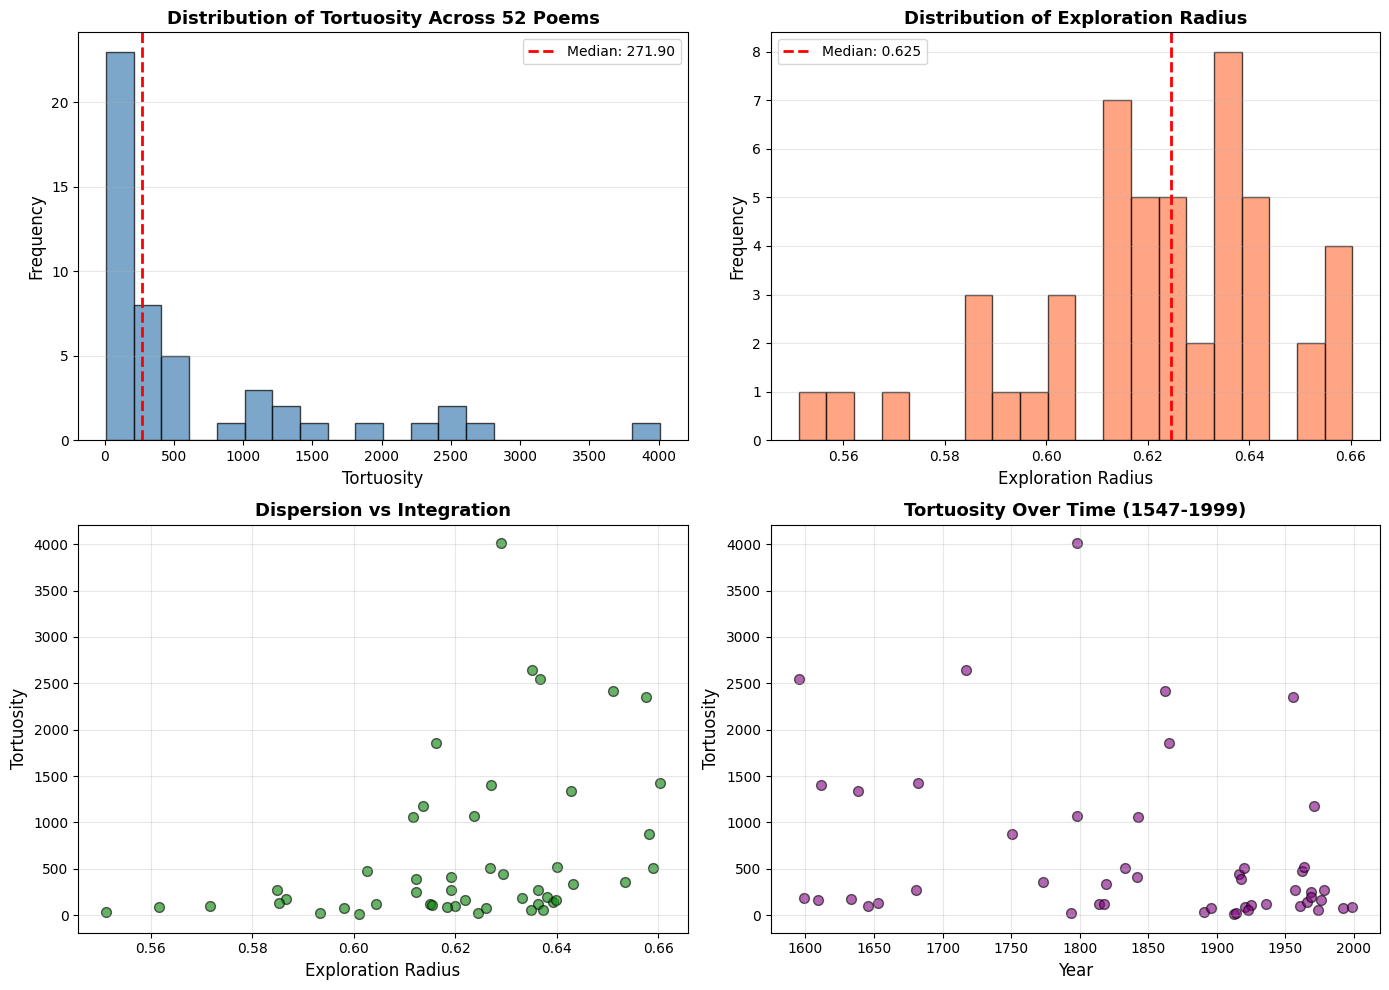

✓ Visualizations complete


In [10]:
# Distribution of Tortuosity
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Tortuosity histogram
axes[0, 0].hist(df_results['tortuosity'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df_results['tortuosity'].median(), color='red', linestyle='--', 
                   linewidth=2, label=f'Median: {df_results["tortuosity"].median():.2f}')
axes[0, 0].set_xlabel('Tortuosity', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Tortuosity Across 52 Poems', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Exploration Radius histogram
axes[0, 1].hist(df_results['exploration_radius'], bins=20, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(df_results['exploration_radius'].median(), color='red', linestyle='--', 
                   linewidth=2, label=f'Median: {df_results["exploration_radius"].median():.3f}')
axes[0, 1].set_xlabel('Exploration Radius', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of Exploration Radius', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Tortuosity vs Exploration Radius scatter
axes[1, 0].scatter(df_results['exploration_radius'], df_results['tortuosity'], 
                   alpha=0.6, s=50, color='green', edgecolors='black')
axes[1, 0].set_xlabel('Exploration Radius', fontsize=12)
axes[1, 0].set_ylabel('Tortuosity', fontsize=12)
axes[1, 0].set_title('Dispersion vs Integration', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Tortuosity over time
axes[1, 1].scatter(df_results['year'], df_results['tortuosity'], 
                   alpha=0.6, s=50, color='purple', edgecolors='black')
axes[1, 1].set_xlabel('Year', fontsize=12)
axes[1, 1].set_ylabel('Tortuosity', fontsize=12)
axes[1, 1].set_title('Tortuosity Over Time (1547-1999)', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## 8. Export Results

In [11]:
# Save to CSV
output_csv = 'corpus_trajectory_results.csv'
df_results.to_csv(output_csv, index=False)
print(f"✓ Results saved to: {output_csv}")

# Save summary statistics
summary_stats = df_results[key_metrics].describe()
summary_stats.to_csv('corpus_trajectory_summary_stats.csv')
print(f"✓ Summary statistics saved to: corpus_trajectory_summary_stats.csv")

# Save metadata as JSON
metadata = {
    'num_poems': len(df_results),
    'date_processed': pd.Timestamp.now().isoformat(),
    'model': 'word2vec-google-news-300',
    'metrics': key_metrics,
    'year_range': [int(df_results['year'].min()), int(df_results['year'].max())],
    'mean_tortuosity': float(df_results['tortuosity'].mean()),
    'median_tortuosity': float(df_results['tortuosity'].median()),
    'mean_exploration_radius': float(df_results['exploration_radius'].mean()),
}

with open('corpus_trajectory_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved to: corpus_trajectory_metadata.json")

print("\n" + "=" * 80)
print("CORPUS ANALYSIS COMPLETE!")
print("=" * 80)
print(f"Processed: {len(df_results)} poems")
print(f"Time span: {df_results['year'].min()}-{df_results['year'].max()}")
print(f"\nMean Tortuosity: {df_results['tortuosity'].mean():.2f}")
print(f"Median Tortuosity: {df_results['tortuosity'].median():.2f}")
print(f"\nOread's Tortuosity: 22.21")
print(f"Oread percentile: {(df_results['tortuosity'] < 22.21).sum() / len(df_results) * 100:.1f}%")

✓ Results saved to: corpus_trajectory_results.csv
✓ Summary statistics saved to: corpus_trajectory_summary_stats.csv
✓ Metadata saved to: corpus_trajectory_metadata.json

CORPUS ANALYSIS COMPLETE!
Processed: 49 poems
Time span: 1595-1999

Mean Tortuosity: 644.53
Median Tortuosity: 271.90

Oread's Tortuosity: 22.21
Oread percentile: 2.0%


## 9. Next Steps

Now that you have trajectory metrics for all 52 real poems:

1. **Generate LLM poems** - Create comparison poems using GPT/Claude
2. **Analyze prose** - Process prose samples for baseline comparison
3. **Statistical tests** - Compare distributions (real vs. LLM vs. prose)
4. **Hypothesis testing** - Test if real poetry shows significantly higher tortuosity
5. **Write paper** - Use results for Cognitive Science publication

**Key prediction**: Real poems will show higher tortuosity than LLM poems or prose, confirming the HIGH DISPERSION + HIGH INTEGRATION hypothesis.